## Q1: Outlier Detection and Removal using Cook’s Distance
Q1.1 — Model choice and justification

- Why did you choose this model (Linear vs Ridge vs Lasso)?
  
  I would choose Linear Regression because it has an OLS hat matrix that could give a close form for Cook’s Distance. Ridge and Lasso would require calculation for leave-one-out influence.

- Why did you choose this library (Statsmodels vs scikit-learn)?
  
  I chose Statsmodels as it gives a built-in Cook’s Distance calculation without requiring custom implementations.

Q1.2 — Identify outliers, remove them, and export clean CSV

- Compute Cook’s Distance for each data point.
- Identify outliers using an appropriate threshold rule (you may use standard rules such as 4/n or justify your own).
- Remove the detected outliers and create a new DataFrame without outliers.
- Export the cleaned dataset to a new CSV file named exactly: usina.csv

In [14]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import statsmodels.api as sm

In [15]:
df = pd.read_csv("usina_with_outliers.csv")

target_col = "PE"
X = df.drop(columns=[target_col])
y = df[target_col]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

influence = model.get_influence()
cooks_d = influence.cooks_distance[0]
df["cooks_distance"] = cooks_d

n = len(df)
threshold = 4 / n

outliers = df["cooks_distance"] > threshold

print(f"Cook's Distance threshold: {threshold:.6f}")
print(f"Number of outliers detected: {outliers.sum()}")

df_clean = df.loc[~outliers].drop(columns=["cooks_distance"])

print(f"Original dataset size: {df.shape[0]}")
print(f"Cleaned dataset size: {df_clean.shape[0]}")

df_clean.to_csv("usina.csv", index=False)

Cook's Distance threshold: 0.000418
Number of outliers detected: 120
Original dataset size: 9568
Cleaned dataset size: 9448


## Q2: Train/Test Evaluation Before vs After Outlier Removal

2.1 Train the above models on usina with outliers.csv and report train/test metrics.

2.2 Train the same models on usina.csv and report train/test metrics.

2.3 Use the following metrics for both train and test: MAE, MSE, R2

2.4 For Ridge and Lasso, use the following λ values: λ ∈ {0.01, 0.1, 1, 10, 100}

In [ ]:
# Original dataset (with outliers)
X = df.drop(columns=[target_col]).copy()
y = df[target_col].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (6697, 5) (6697, 1)
Test : (2871, 5) (2871, 1)


In [17]:
def eval_metrics(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return {
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2":  r2_score(y_true, y_pred),
    }

In [18]:
def fit_and_report_basic_models(Xt_tr, Xt_te, y_train, y_test):
    models = {
        "Linear": LinearRegression(),
        "Ridge(alpha=0.01)": Ridge(alpha=0.01, random_state=42),
        "Ridge(alpha=0.1)": Ridge(alpha=0.1, random_state=42),
        "Ridge(alpha=1)": Ridge(alpha=1.0, random_state=42),
        "Ridge(alpha=10)": Ridge(alpha=10, random_state=42),
        "Ridge(alpha=100)": Ridge(alpha=100, random_state=42),
        "Lasso(alpha=0.01)": Lasso(alpha=0.01, max_iter=50000, random_state=42),
        "Lasso(alpha=0.1)": Lasso(alpha=0.1, max_iter=50000, random_state=42),
        "Lasso(alpha=1)": Lasso(alpha=1.0, max_iter=50000, random_state=42),
        "Lasso(alpha=10)": Lasso(alpha=10, max_iter=50000, random_state=42),
        "Lasso(alpha=100)": Lasso(alpha=100, max_iter=50000, random_state=42),
    }

    rows = []


    for name, model in models.items():
        model.fit(Xt_tr, y_train.ravel())
        pred_tr = model.predict(Xt_tr).reshape(-1,1)
        pred_te = model.predict(Xt_te).reshape(-1,1)
        
        pred_tr_eval = pred_tr
        pred_te_eval = pred_te
        yt_tr_eval = y_train
        yt_te_eval = y_test

        mtr = eval_metrics(yt_tr_eval, pred_tr_eval)
        mte = eval_metrics(yt_te_eval, pred_te_eval)

        rows.append({
            "model": name,
            **{f"train_{k}": v for k,v in mtr.items()},
            **{f"test_{k}": v for k,v in mte.items()},
        })
    return pd.DataFrame(rows)

part2_results = fit_and_report_basic_models(X_train.values, X_test.values, y_train, y_test)
display(part2_results)

,model,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
0,Linear,122.238868,5.196009,0.653418,133.211629,5.078700,0.619439
1,Ridge(alpha=0.01),122.238870,5.196011,0.653418,133.202268,5.078672,0.619465
2,Ridge(alpha=0.1),122.238992,5.196028,0.653418,133.118979,5.078421,0.619703
3,Ridge(alpha=1),122.249246,5.196195,0.653389,132.371038,5.076147,0.621840
4,Ridge(alpha=10),122.539911,5.197236,0.652564,128.857790,5.065140,0.631877
5,Ridge(alpha=100),123.194014,5.198980,0.650710,125.755267,5.055234,0.640740
6,Lasso(alpha=0.01),122.309391,5.196175,0.653218,131.052357,5.071730,0.625607
7,Lasso(alpha=0.1),123.384607,5.201739,0.650169,125.134495,5.055348,0.642514
8,Lasso(alpha=1),123.421151,5.229507,0.650066,125.338356,5.083092,0.641931
9,Lasso(alpha=10),126.141514,5.540418,0.642353,128.902136,5.408803,0.631750


In [ ]:
# Cleaned dataset
df2 = pd.read_csv("usina.csv")
X2 = df2.drop(columns=[target_col]).copy()
y2 = df2[target_col].values.reshape(-1, 1)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.30, random_state=42, shuffle=True
)

print("Train:", X2_train.shape, y2_train.shape)
print("Test :", X2_test.shape, y2_test.shape)

Train: (6613, 4) (6613, 1)
Test : (2835, 4) (2835, 1)


In [20]:
part2b_results = fit_and_report_basic_models(X2_train.values, X2_test.values, y2_train, y2_test)
display(part2b_results)

,model,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
0,Linear,19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
1,Ridge(alpha=0.01),19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
2,Ridge(alpha=0.1),19.864671,3.596397,0.931369,20.396770,3.624773,0.930302
3,Ridge(alpha=1),19.864671,3.596400,0.931369,20.396750,3.624774,0.930302
4,Ridge(alpha=10),19.864672,3.596430,0.931369,20.396549,3.624783,0.930303
5,Ridge(alpha=100),19.864758,3.596742,0.931369,20.394626,3.624880,0.930310
6,Lasso(alpha=0.01),19.864675,3.596368,0.931369,20.396738,3.624754,0.930302
7,Lasso(alpha=0.1),19.865263,3.596855,0.931367,20.392600,3.624890,0.930316
8,Lasso(alpha=1),19.929852,3.605523,0.931144,20.414755,3.631153,0.930241
9,Lasso(alpha=10),25.685683,4.086632,0.911258,26.157253,4.120464,0.910618


Discussion

Briefly discuss what you observe in terms of train vs test performance:
- Do outliers change train error? Test error?
  
  Both the train and test error reduces when outliers are removed. Test/Train MSE drops from around 122 with outliers to around 20 without outliers, while test/train MAE drops from 5 to 3 when outliers are removed.
- Which dataset (with outliers vs without outliers) shows better generalization?
  
  The dataset without outliers shows better generalization due to test R^2 at 0.93 compared to around 0.6 with outliers.
- Do Ridge/Lasso appear to help relative to standard linear regression?
  
  Ridge/Lasso helps with the dataset with outliers as shown in the table by slightly improved test R^2 and decreased test error. However, they are no significantly better than Linear Regression with the outlier-removed dataset.

## Q3: Reliability of Coefficients (Use Outlier-Removed Dataset)
Q3.1 — Method choice and scaling decision
- Why did you choose this model (Linear vs Ridge vs Lasso)?

  I chose linear regression for investigating reliability of regression coefficients, as Lasso and Ridge tends to quickly shrink some of the coefficients so these two models do something similar to "force" reliability.
- Why did you choose this library (Statsmodels vs scikit-learn)?

  I chose scikit-learn as it is more easily for integrating the bootstrap idea to check realibility.
- Would you scale IVs and/or DV for this coefficient reliability task?

  I wouldn't do any scaling for this task.

- Justify your answer clearly (why scaling helps or hurts for what you want to measure).
  
  Whether IVs are scaled or not doesn't affect their t scores. Scaling is more important in comparing which features are more important than others.

Q3.2 — Implementation and results
- Implement your approach and identify the most reliable and least reliable coefficient.
  
  The most reliable coefficient is AT, the least reliable coefficient is AP.
- Clearly report your reasoning and show the outputs you used to make the decision.
  
  I used the OLS t-statistics to evaluate the reliability of the coefficients. The greater the magnitude of the t value of that coefficient, the higher the reliability of that coefficient.

In [21]:
def linear_with_ols_reports(Xt_tr, Xt_te, y_train, y_test, feature_names):
    lr = LinearRegression()
    lr.fit(Xt_tr, y_train.ravel())

    pred_tr = lr.predict(Xt_tr).reshape(-1, 1)
    pred_te = lr.predict(Xt_te).reshape(-1, 1)

    mtr = eval_metrics(y_train, pred_tr)
    mte = eval_metrics(y_test, pred_te)

    # OLS (t-stats) on the same training design matrix
    X_sm = sm.add_constant(Xt_tr)
    ols = sm.OLS(y_train, X_sm).fit()

    feat_names = ["const"] + list(feature_names)
    ols_table = pd.DataFrame({
        "term": feat_names,
        "beta_hat": ols.params.reshape(-1),
        "t_value": ols.tvalues.reshape(-1),
        "p_value": ols.pvalues.reshape(-1)
    }).sort_values("t_value", key=np.abs, ascending=False)

    beta = lr.coef_.reshape(-1)
    coef_table = pd.DataFrame({
        "feature": feature_names,
        "coef_value": beta
    }).sort_values("coef_value", key=np.abs, ascending=False)

    return {
        "train_metrics": mtr,
        "test_metrics": mte,
        "coef_table": coef_table,
        "ols_table": ols_table
    }

feature_names = df2.drop(columns=[target_col]).columns.tolist()
lin_reports = linear_with_ols_reports(X2_train.values, X2_test.values, y2_train, y2_test, feature_names)

print(f"\n{'='*90}")
print(f"LINEAR REGRESSION REPORT")
print(f"{'-'*90}")
print("Train metrics:", {k: round(v, 6) for k,v in lin_reports['train_metrics'].items()})
print("Test  metrics:", {k: round(v, 6) for k,v in lin_reports['test_metrics'].items()})

print("\nOLS t-statistics (studentized coefficients):")
display(lin_reports["ols_table"])



LINEAR REGRESSION REPORT
------------------------------------------------------------------------------------------
Train metrics: {'mse': 19.864671, 'mae': 3.596396, 'r2': 0.931369}
Test  metrics: {'mse': 20.396772, 'mae': 3.624773, 'r2': 0.930302}

OLS t-statistics (studentized coefficients):


,term,beta_hat,t_value,p_value
1,AT,-1.966193,-108.971834,0.000000e+00
0,const,443.753358,38.455715,3.717392e-292
4,RH,-0.150944,-31.237663,6.360165e-200
2,V,-0.234557,-27.390969,1.487453e-156
3,AP,0.072105,6.438038,1.295207e-10


## Q4: Most Important vs Least Important Features (Use Outlier-Removed Dataset)
Q4.1 — Method choice and scaling decision

- Why did you choose this model (Linear vs Ridge vs Lasso)?
  
  I chose Linear Regression, as Ridge and Lasso Regression tends to shrink some coefficients down really quickly but that largely relies on the lamda/hyperparameter values by our choice. Thus, OLS seems to be the fairest choice here.
- Why did you choose this library (Statsmodels vs scikit-learn)?

  I chose scikit-learn as it is fast and efficient for the simple Linear Regression task.
- Would you scale IVs and/or DV for this feature importance task?
  
  Yes, I would.
- Justify your answer clearly (why scaling affects coefficient magnitude comparisons and importance).
 
  IVs have different units thus naturally some IVs have larger numbers than the other ones. If not scaling to the unitless and comparable IVs, the model gives unfair penalties to IVs with naturally small magnitudes.

Q4.2 — Implementation and results
- Implement your approach and identify the most important and least important feature.
  
  The most important feature is AT with the standardized coefficient of the greatest magnitude -14.6. The least important feature is AP with the smallest absolute standardized coefficient of 0.4.

In [22]:
def linear_stdcoef_report(Xt_tr, Xt_te, y_train, y_test, feature_names):
    # Scale X only (fit on train, transform train + test)
    x_scaler = StandardScaler()
    Xt_tr_sc = x_scaler.fit_transform(Xt_tr)
    Xt_te_sc = x_scaler.transform(Xt_te)

    # Fit LR on scaled X, original y (no y scaling)
    lr = LinearRegression()
    lr.fit(Xt_tr_sc, y_train.ravel())

    pred_tr = lr.predict(Xt_tr_sc).reshape(-1, 1)
    pred_te = lr.predict(Xt_te_sc).reshape(-1, 1)

    mtr = eval_metrics(y_train, pred_tr)
    mte = eval_metrics(y_test, pred_te)

    beta_std = lr.coef_.reshape(-1)

    beta_unstd = lr.coef_.reshape(-1) / x_scaler.scale_

    coef_table = pd.DataFrame({
        "feature": feature_names,
        "coef_unstandardized": beta_unstd,
        "coef_standardized": beta_std
    }).sort_values("coef_standardized", key=np.abs, ascending=False)


    return {
        "train_metrics": mtr,
        "test_metrics": mte,
        "coef_table": coef_table
    }

report_4 = linear_stdcoef_report(X2_train.values, X2_test.values, y2_train, y2_test, feature_names)

print("Train metrics:", {k: round(v, 6) for k, v in report_4["train_metrics"].items()})
print("Test  metrics:", {k: round(v, 6) for k, v in report_4["test_metrics"].items()})

display(report_4["coef_table"])

Train metrics: {'mse': 19.864671, 'mae': 3.596396, 'r2': 0.931369}
Test  metrics: {'mse': 20.396772, 'mae': 3.624773, 'r2': 0.930302}


,feature,coef_unstandardized,coef_standardized
0,AT,-1.966193,-14.637188
1,V,-0.234557,-2.979022
3,RH,-0.150944,-2.230954
2,AP,0.072105,0.428372


## Q5: Regularization Paths (Scaled Data, Outlier-Removed Dataset)
5.1 Implement both Ridge Regression and Lasso Regression

5.2 Choose an appropriate range for λ and generate 100 values in that range. (Hint: a log-spaced range is usually a good idea.)

5.3 For each λ, fit the model and record coefficient values.

5.4 Plot coefficient value vs. λ for:
- Ridge
- Lasso

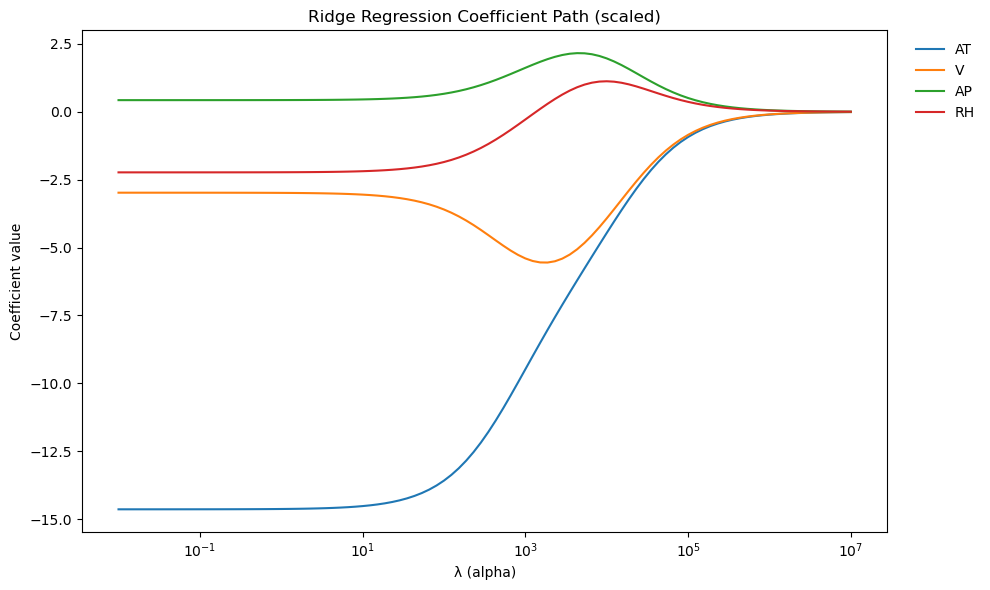

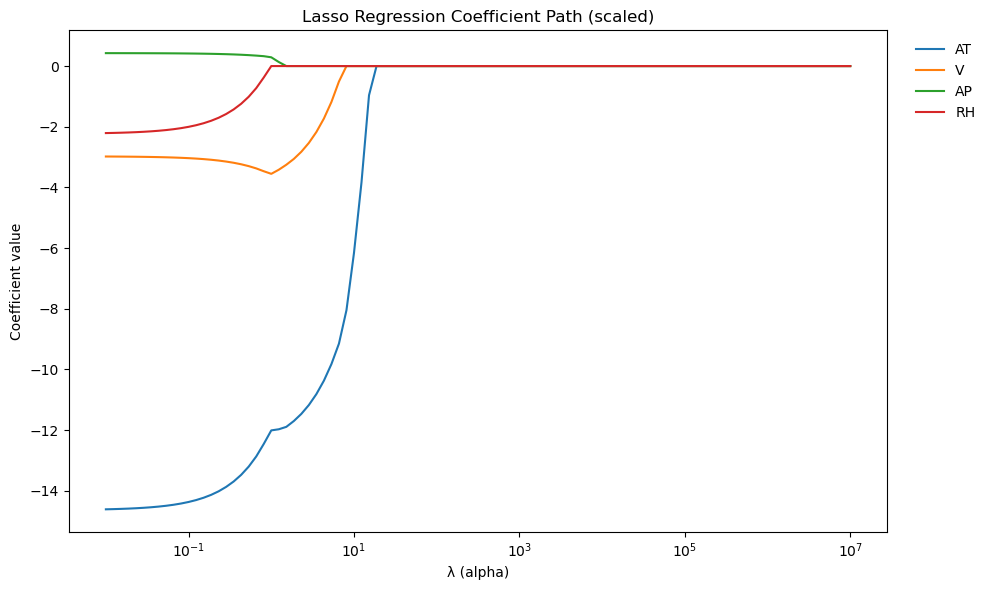

In [31]:
lambda_grid = np.logspace(-2, 7, 100)

def record_coef_path(model_type: str, Xt_tr, y_tr, lambda_grid: np.ndarray):
    coefs = []
    x_scaler = StandardScaler()
    Xt_tr_sc = x_scaler.fit_transform(Xt_tr)
    for lam in lambda_grid:
        if model_type == "Ridge":
            model = Ridge(alpha=lam, random_state=42)
        elif model_type == "Lasso":
            model = Lasso(alpha=lam, max_iter=50000, random_state=42)

        model.fit(Xt_tr_sc, y_tr.ravel())
        coefs.append(model.coef_.reshape(-1))

    return np.vstack(coefs)

ridge_path = record_coef_path("Ridge", X2_train.values, y2_train, lambda_grid)
lasso_path = record_coef_path("Lasso", X2_train.values, y2_train, lambda_grid)

plt.figure(figsize=(10, 6))

assert len(feature_names) == ridge_path.shape[1]

for j in range(ridge_path.shape[1]):
    plt.plot(lambda_grid, ridge_path[:, j], label=feature_names[j])

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.xscale("log")
plt.xlabel("λ (alpha)")
plt.ylabel("Coefficient value")
plt.title("Ridge Regression Coefficient Path (scaled)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
assert len(feature_names) == lasso_path.shape[1]

for j in range(lasso_path.shape[1]):
    plt.plot(lambda_grid, lasso_path[:, j], label=feature_names[j])

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.xscale("log")
plt.xlabel("λ (alpha)")
plt.ylabel("Coefficient value")
plt.title("Lasso Regression Coefficient Path (scaled)")
plt.tight_layout()
plt.show()


- What happens to coefficients as λ increases in Ridge vs Lasso?
  
  The coefficient approaches zero but never reaches zero as λ increases in Ridge regression. In Lasso regression, the coefficients get pushed to zero as λ increases.
- Which regression is better under multicollinearity in IVs, and why?
  
  Ridge regression is better under multicollinearity, as it keeps all features instead of picking one out of all with multicollinearity and removes the others like in Lasso regression.
- Which regression is better for feature selection, and why?
  
  Lasso regression is better for feature selection. According to the graph, coefficients are pushed to zero thus selecting features that matter the most.